In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movies-on-netflix-prime-video-hulu-and-disney/MoviesOnStreamingPlatforms_updated.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn import preprocessing
from scipy.sparse import hstack
import pandas_profiling

In [3]:
#load dataset
df = pd.read_csv("/kaggle/input/movies-on-netflix-prime-video-hulu-and-disney/MoviesOnStreamingPlatforms_updated.csv")

In [4]:
df = df.iloc[:, 1:]    #remove unnamed index column
df.head()

,ID,Title,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type,Directors,Genres,Country,Language,Runtime
0,1,Inception,2010,13+,8.8,87%,1,0,0,0,0,Christopher Nolan,"Action,Adventure,Sci-Fi,Thriller","United States,United Kingdom","English,Japanese,French",148.0
1,2,The Matrix,1999,18+,8.7,87%,1,0,0,0,0,"Lana Wachowski,Lilly Wachowski","Action,Sci-Fi",United States,English,136.0
2,3,Avengers: Infinity War,2018,13+,8.5,84%,1,0,0,0,0,"Anthony Russo,Joe Russo","Action,Adventure,Sci-Fi",United States,English,149.0
3,4,Back to the Future,1985,7+,8.5,96%,1,0,0,0,0,Robert Zemeckis,"Adventure,Comedy,Sci-Fi",United States,English,116.0
4,5,"The Good, the Bad and the Ugly",1966,18+,8.8,97%,1,0,1,0,0,Sergio Leone,Western,"Italy,Spain,West Germany",Italian,161.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16744 entries, 0 to 16743
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               16744 non-null  int64  
 1   Title            16744 non-null  object 
 2   Year             16744 non-null  int64  
 3   Age              7354 non-null   object 
 4   IMDb             16173 non-null  float64
 5   Rotten Tomatoes  5158 non-null   object 
 6   Netflix          16744 non-null  int64  
 7   Hulu             16744 non-null  int64  
 8   Prime Video      16744 non-null  int64  
 9   Disney+          16744 non-null  int64  
 10  Type             16744 non-null  int64  
 11  Directors        16018 non-null  object 
 12  Genres           16469 non-null  object 
 13  Country          16309 non-null  object 
 14  Language         16145 non-null  object 
 15  Runtime          16152 non-null  float64
dtypes: float64(2), int64(7), object(7)
memory usage: 2.0+ MB


In [6]:
df.Type.unique()

array([0])

# Work with missing values

In [7]:
df.isnull().sum()

ID                     0
Title                  0
Year                   0
Age                 9390
IMDb                 571
Rotten Tomatoes    11586
Netflix                0
Hulu                   0
Prime Video            0
Disney+                0
Type                   0
Directors            726
Genres               275
Country              435
Language             599
Runtime              592
dtype: int64

Here we can see Age and Rotten tomatoes has lots of missing values

**lets find percentage of missing values**

In [8]:
miss = pd.DataFrame(df.isnull().sum())
miss = miss.rename(columns={0: "miss_count"})
miss["missing%"] = (miss.miss_count/len(df.ID))*100
miss

,miss_count,missing%
ID,0,0.000000
Title,0,0.000000
Year,0,0.000000
Age,9390,56.079790
IMDb,571,3.410177
Rotten Tomatoes,11586,69.194935
Netflix,0,0.000000
Hulu,0,0.000000
Prime Video,0,0.000000
Disney+,0,0.000000


#### Itss clearly visible that Age and Rotten tomatoes has more than 50% missing values

1. Drop columns which has more than 50% missing values
2. Drop NA from less than 50%
3. Reset Index

In [9]:
#mssing %>50%
df.drop(['Rotten Tomatoes', 'Age'], axis =1, inplace=True)
# dropping NA from following columns
df.dropna(subset=[
    'IMDb', 'Directors', 'Genres', 'Country', 'Language', 'Runtime'
], inplace = True)

df.reset_index(inplace=True, drop=True)

#converting into object tyype

df.Year = df.Year.astype("object")

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15233 entries, 0 to 15232
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           15233 non-null  int64  
 1   Title        15233 non-null  object 
 2   Year         15233 non-null  object 
 3   IMDb         15233 non-null  float64
 4   Netflix      15233 non-null  int64  
 5   Hulu         15233 non-null  int64  
 6   Prime Video  15233 non-null  int64  
 7   Disney+      15233 non-null  int64  
 8   Type         15233 non-null  int64  
 9   Directors    15233 non-null  object 
 10  Genres       15233 non-null  object 
 11  Country      15233 non-null  object 
 12  Language     15233 non-null  object 
 13  Runtime      15233 non-null  float64
dtypes: float64(2), int64(6), object(6)
memory usage: 1.6+ MB


# Lets visualize by plots

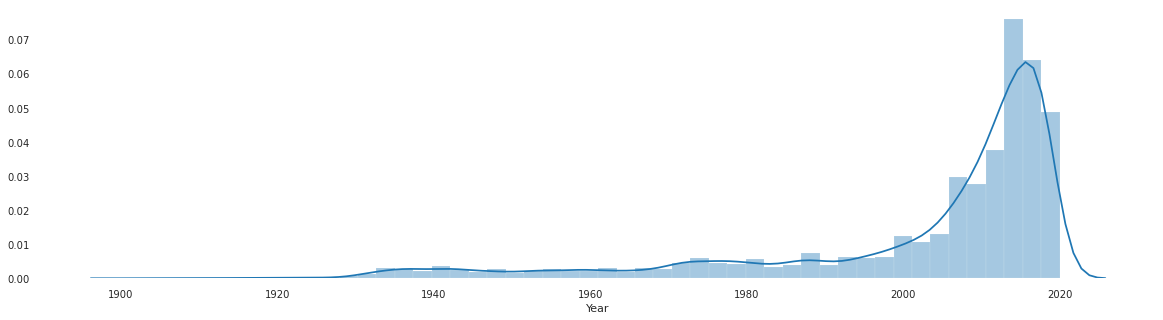

In [11]:
#check distribution of year using distplot
plt.figure(figsize = (20, 5))
sns.distplot(df['Year'])
plt.show()


 most movies are made between 2000 to 2020

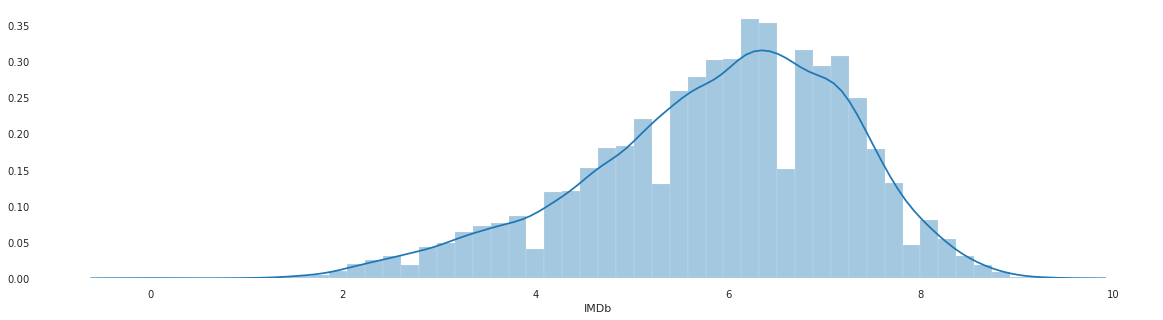

In [12]:
#distribution of IMDB Rating
plt.figure(figsize = (20,5))
sns.distplot(df['IMDb'])
plt.show()


lots of movies lies between 5 to 7

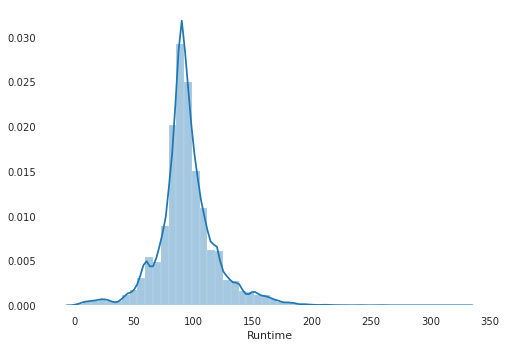

In [13]:
# lets plot the length of movies
sns.distplot(df['Runtime'])
plt.show()

## Lets distribute the movie based on platforms

In [14]:
def movie_count(platform, count=False):
    """A function to count the movies in differnet Streaming platform"""
    if count==False:
        print('Platform {} Count : {}'.format(platform, df[platform].sum()))
        
    else:
        return df[platform].sum()

In [15]:
#lets see the count
movie_count('Netflix')
movie_count('Prime Video')
movie_count('Disney+')

Platform Netflix Count : 3152
Platform Prime Video Count : 11289
Platform Disney+ Count : 542


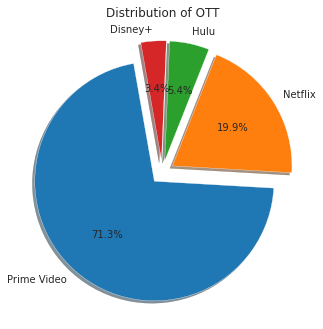

In [16]:
#lets find on each plaform
platform = 'Prime Video', 'Netflix', 'Hulu', 'Disney+'
s = [movie_count('Prime Video', count = True),
     movie_count('Netflix', count = True),
     movie_count('Hulu', count = True),
     movie_count('Disney+', count = True),
    ]

explode= (0.1, 0.1, 0.1, 0.1)

#plot
fig1, ax1 = plt.subplots()
ax1.pie(s, 
       labels = platform,
       autopct = '%1.1f%%',
       explode = explode,
       shadow = True,
       startangle=100)

ax1.axis = ('equal')
plt.title('Distribution of OTT')
plt.show()

# Movie Distribution according to GENRE

In [17]:
# split genre by ',' and then stack it one after the other.
#apply will create the mupltiple columns for each genre and 'stack' will stack them
#in single column

g = df['Genres'].str.split(',').apply(pd.Series,1).stack()

g.index = g.index.droplevel(-1)

#assign name
g.name = 'Genres'

#delete column

del df['Genres']

#join new column
df_genres = df.join(g)



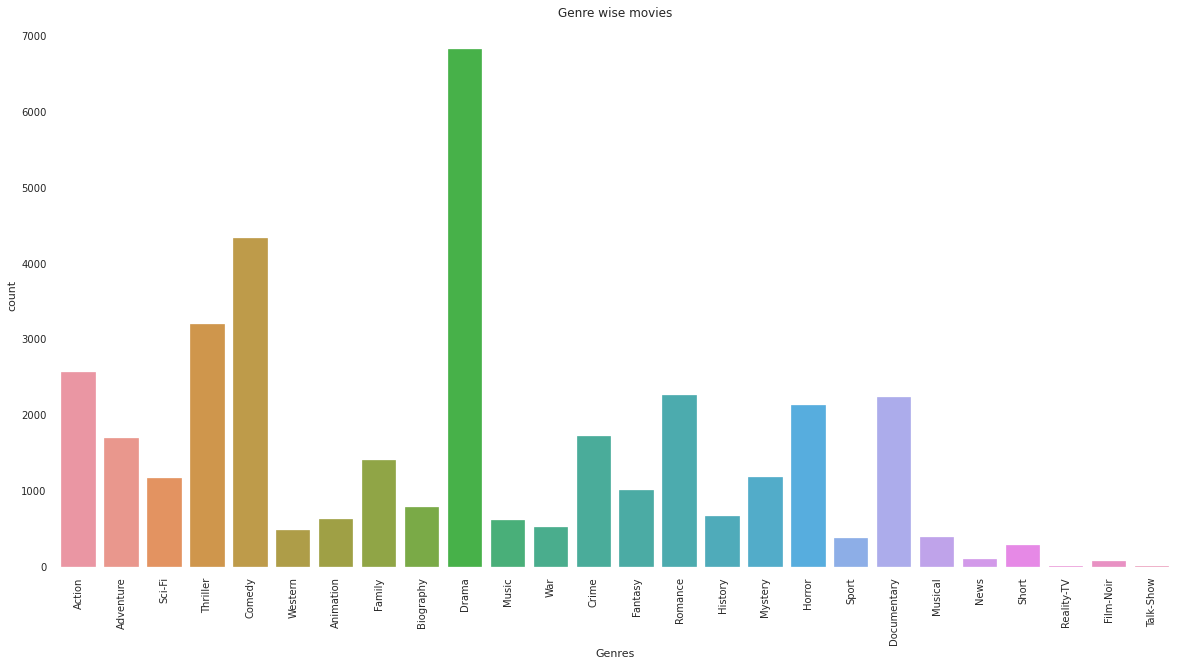

In [18]:
plt.figure(figsize=(20,10))
sns.countplot(x='Genres', data = df_genres)
plt.xticks(rotation=90)
plt.title("Genre wise movies")
plt.show()

# distribute according to country

In [19]:
#same process as above 
#split-->apply-->stack()

c = df['Country'].str.split(',').apply(pd.Series, 1).stack()
c.index = c.index.droplevel(-1)

#assign name
c.name = 'Country'

#delete column
del df['Country']

df_country = df.join(c)

In [20]:
df_country.head()

,ID,Title,Year,IMDb,Netflix,Hulu,Prime Video,Disney+,Type,Directors,Language,Runtime,Country
0,1,Inception,2010,8.8,1,0,0,0,0,Christopher Nolan,"English,Japanese,French",148.0,United States
0,1,Inception,2010,8.8,1,0,0,0,0,Christopher Nolan,"English,Japanese,French",148.0,United Kingdom
1,2,The Matrix,1999,8.7,1,0,0,0,0,"Lana Wachowski,Lilly Wachowski",English,136.0,United States
2,3,Avengers: Infinity War,2018,8.5,1,0,0,0,0,"Anthony Russo,Joe Russo",English,149.0,United States
3,4,Back to the Future,1985,8.5,1,0,0,0,0,Robert Zemeckis,English,116.0,United States


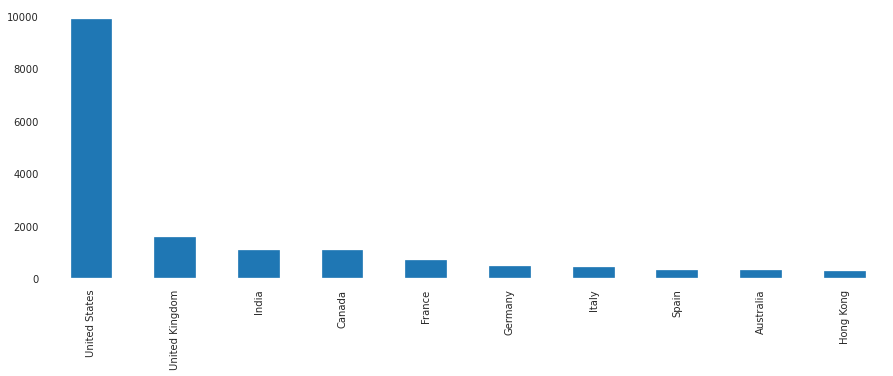

In [21]:
#plot
df_country['Country'].value_counts()[:10].plot(kind="bar", figsize=(15,5))
plt.show()

# Distribute according to language

In [22]:
#split
l = df['Language'].str.split(',').apply(pd.Series,1).stack()

l.index = l.index.droplevel(-1)

l.name = "Language"

del df['Language']

df_language = df.join(l)

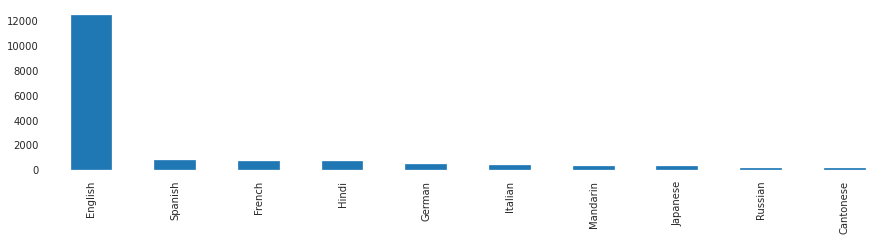

In [23]:
df_language['Language'].value_counts()[:10].plot(kind = 'bar', figsize =(15,3))
plt.show()

# Distribute IMDB rating on Each Platform

In [24]:
df.columns

Index(['ID', 'Title', 'Year', 'IMDb', 'Netflix', 'Hulu', 'Prime Video',
       'Disney+', 'Type', 'Directors', 'Runtime'],
      dtype='object')

In [25]:
#apply melt() function --> converts wide dataframe into a long dataframe
df_Imdb = pd.melt(df, id_vars = ['ID', 'Title', 'Year', 'IMDb', 'Type', 'Runtime'], var_name = 'platform')

df_Imdb = df_Imdb[df_Imdb.value==1]
df_Imdb.drop(columns=["value"], axis=1, inplace=True)


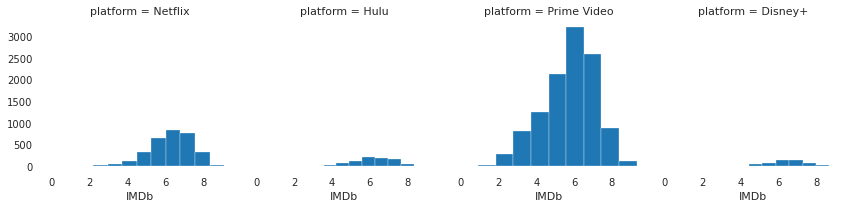

In [26]:
#plot the graph
g = sns.FacetGrid(df_Imdb, col="platform")
g.map(plt.hist, "IMDb")
plt.show()

# Runtime per platform alogn the age group

In [27]:
# we have already droped the Age 
#lets reload the data
df = pd.read_csv("/kaggle/input/movies-on-netflix-prime-video-hulu-and-disney/MoviesOnStreamingPlatforms_updated.csv")
df=df.iloc[:,1:]
df.ID = df.ID.astype("object")

# melting platform columns to create visualization
df2 = pd.melt(df, id_vars=["ID","Title","Year","Age","IMDb","Rotten Tomatoes","Type","Runtime"], var_name="platform")
df2 = df2[df2.value==1]
df2.drop(columns=["value"],axis=1,inplace=True)

In [28]:
df2.head(5)

,ID,Title,Year,Age,IMDb,Rotten Tomatoes,Type,Runtime,platform
0,1,Inception,2010,13+,8.8,87%,0,148.0,Netflix
1,2,The Matrix,1999,18+,8.7,87%,0,136.0,Netflix
2,3,Avengers: Infinity War,2018,13+,8.5,84%,0,149.0,Netflix
3,4,Back to the Future,1985,7+,8.5,96%,0,116.0,Netflix
4,5,"The Good, the Bad and the Ugly",1966,18+,8.8,97%,0,161.0,Netflix


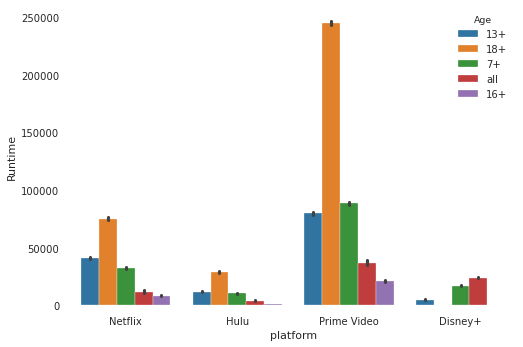

In [29]:
# Total runtime in different platform

ax = sns.barplot(x="platform", y="Runtime",hue="Age", estimator=sum, data=df2)


# LEts build our model

There are three ttypes of recommender systems:
1. **Content based methods**
2. **Collaborative Filtering Methods**
3. **Hybrid Methods**

In [30]:
#load data again
df = pd.read_csv("/kaggle/input/movies-on-netflix-prime-video-hulu-and-disney/MoviesOnStreamingPlatforms_updated.csv")
df = df.iloc[:, 1:]

In [31]:
#find missing values
miss = pd.DataFrame(df.isnull().sum())
miss = miss.rename(columns={0: "miss_count"})
miss["missing%"] = (miss.miss_count/len(df.ID))*100
miss

,miss_count,missing%
ID,0,0.000000
Title,0,0.000000
Year,0,0.000000
Age,9390,56.079790
IMDb,571,3.410177
Rotten Tomatoes,11586,69.194935
Netflix,0,0.000000
Hulu,0,0.000000
Prime Video,0,0.000000
Disney+,0,0.000000


In [32]:
#mssing %>50%
df.drop(['Rotten Tomatoes', 'Age'], axis =1, inplace=True)
# dropping NA from following columns
df.dropna(subset=[
    'IMDb', 'Directors', 'Genres', 'Country', 'Language', 'Runtime'
], inplace = True)

df.reset_index(inplace=True, drop=True)

#converting into object tyype

df.Year = df.Year.astype("object")
df.ID = df.ID.astype("object")

# Lets build two recomendor system

### 1. Using only Numerical column

In [33]:
#select variable
numerical_df = df.select_dtypes(include=['float64', "int64"])

 scaling the numerical variable using a minmax scaler to reduce model complexity

In [34]:
#use preprocessing

#create minmax scaler
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

#create dataframe
numerical_df_max = pd.DataFrame((scaler.fit_transform(numerical_df)))

#assign column names
numerical_df_max.columns = numerical_df.columns

numerical_df_max.head()

,IMDb,Netflix,Hulu,Prime Video,Disney+,Type,Runtime
0,0.946237,1.0,0.0,0.0,0.0,0.0,0.449541
1,0.935484,1.0,0.0,0.0,0.0,0.0,0.412844
2,0.913978,1.0,0.0,0.0,0.0,0.0,0.452599
3,0.913978,1.0,0.0,0.0,0.0,0.0,0.351682
4,0.946237,1.0,0.0,1.0,0.0,0.0,0.489297


compute similarity score

In [35]:
from sklearn.metrics.pairwise import cosine_similarity

#compute cosine similarity
sig = cosine_similarity(numerical_df_max, numerical_df_max)

#reverse maping of indices and titles
indices = pd.Series(df.index, index = df['Title']).drop_duplicates()

In [37]:
indices.head()

Title
Inception                         0
The Matrix                        1
Avengers: Infinity War            2
Back to the Future                3
The Good, the Bad and the Ugly    4
dtype: int64

write a function to get recomedation based on similartiy score

In [38]:
def give_recomendation(title, sig = sig):
    """return the index of series of indices"""
    #get the index corresponding to original_title
    idx = indices[title]
    
    #get the pairwise similarity scores
    sig_scores = list(enumerate(sig[idx]))
    
    #sort the movies
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)
    
    #scores of 10 most similar movies
    movie_indices = [i[0] for i in sig_scores]
    #top 10 most similar movies
    return df['Title'].iloc[movie_indices]

In [39]:
#lets try
give_recomendation("The Matrix", sig= sig)

1                              The Matrix
1269               Eh Janam Tumhare Lekhe
747                     Khosla Ka Ghosla!
167                            Article 15
0                               Inception
                       ...               
13989                      Shark Exorcist
14281     Justin Bieber: Always Believing
12711         Justin Bieber: Rise to Fame
12827    In Memoriam Alexander Litvinenko
12828       From Philadelphia To Fallujah
Name: Title, Length: 15233, dtype: object

Here, recommended movies are not up to the mark. The reason behind this poor result is that you are using only movie ratings, movie runtimes, and platform variables. You can improve this by using other information such as genre, directors, and country.

### 2. Using Numerical and Textual Columns

#### STep 1 
use textual columns into single column then use tokenizer and TF-IDF Vectorizer to create a sparse matrix.
* Selecting all object data types and storing them in a list.
* Removing ID and Title column.
* Joining all text/object columns using commas into a single column.
* Creating a tokenizer to remove unwanted elements from our data like symbols and numbers.
* Converting TfidfVector from the text After that we will do numerical columns pre-processing
* Selecting numerical variables into a data Frame
* Scaling Numerical variables using minmax scaler (0,1) range
* Adding numerical variables in the TF-IDF vectors sparse matrix using hstack function (hstack is used to add horizontal arrays into a sparse matrix).

In [41]:
#the function performs all the important preprocessing steps
def preprocess(df):
    
    #combining all text columns
    # Selecting all object data type and storing them in list
    s = list(df.select_dtypes(include=['object']).columns)
    
    
    # Removing ID and Title column
    s.remove("Title")
    s.remove("ID")
    
    # Joining all text/object columns using commas into a single column
    df['all_text']= df[s].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)

    # Creating a tokenizer to remove unwanted elements from our data like symbols and numbers
    token = RegexpTokenizer(r'[a-zA-Z]+')

    # Converting TfidfVector from the text
    cv = TfidfVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
    text_counts= cv.fit_transform(df['all_text'])

    # Aelecting numerical variables
    ndf = df.select_dtypes(include=['float64',"int64"])

    # Scaling Numerical variables
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

    # Applying scaler on our data and converting i into a data frame
    ndfmx = pd.DataFrame((scaler.fit_transform(ndf)))
    ndfmx.columns=ndf.columns    

    # Adding our adding numerical variables in the TF-IDF vector
    IMDb = ndfmx.IMDb.values[:, None]
    X_train_dtm = hstack((text_counts, IMDb))
    
    Netflix = ndfmx.Netflix.values[:, None]
    X_train_dtm = hstack((X_train_dtm, Netflix))
    
    Hulu = ndfmx.Hulu.values[:, None]
    X_train_dtm = hstack((X_train_dtm, Hulu))
    
    Prime = ndfmx["Prime Video"].values[:, None]
    X_train_dtm = hstack((X_train_dtm, Prime))
    
    Disney = ndfmx["Disney+"].values[:, None]
    X_train_dtm = hstack((X_train_dtm, Disney))
    
    Runtime = ndfmx.Runtime.values[:, None]
    X_train_dtm = hstack((X_train_dtm, Runtime))
    
    return X_train_dtm

#### Step 2 : applying the function to our data and creating a sparse matrix

In [42]:
# Preprocessing data
mat = preprocess(df)
mat.shape

(15233, 11997)

#### Step 3: Again apply cosine similarity to compute the similarity score

In [43]:
# using cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

#compute the sigmoid kernel
sig2= cosine_similarity(mat, mat)

#reverse mapping of indices and movie titles
indices = pd.Series(df.index, index=df['Title']).drop_duplicates()

#### Step4 : Getting a recommendation from our improved system

In [46]:
give_recomendation("The Matrix", sig = sig2)

1                              The Matrix
81                    The Matrix Reloaded
245                The Matrix Revolutions
755                     Jupiter Ascending
154                        Miss Americana
                       ...               
12931             Return of the Boogeyman
14281     Justin Bieber: Always Believing
12711         Justin Bieber: Rise to Fame
12827    In Memoriam Alexander Litvinenko
12828       From Philadelphia To Fallujah
Name: Title, Length: 15233, dtype: object

### So finally we have made a basic recommendor system.

Feel free to fork and improve the model.

**Sources**:
* Data Cammp
* Medium
* Kaggle

# The End